## Sensitivity analysis for orbital relative motion with Clohessy–Wiltshire equations


We will focus on modelling orbital relative motion with the Clohessy-Wiltshire equations. This set of equations was taught in AA 528 and consist of a linear set of differential equations, making them easier to implement compared to the 6 degrees-of-freedom nonlinear equations of the Lunar Lander presented in [1]. This allows us to implement the sensitivity analysis concept from [1] to a new dynamical system.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [28]:
#### Define Constants ####

mu = 3.9860 * 10**5 #Earths gravitational parameter
R_Target = 400 
R_Earth = 6378 
R_total = R_Earth + R_Target
omega = np.sqrt(mu / R_total**3)

In [51]:
#### Initial Conditions #### 

r_init = np.array([1, 0, 1])
rdot_init = np.array([0.1, 0, 0])


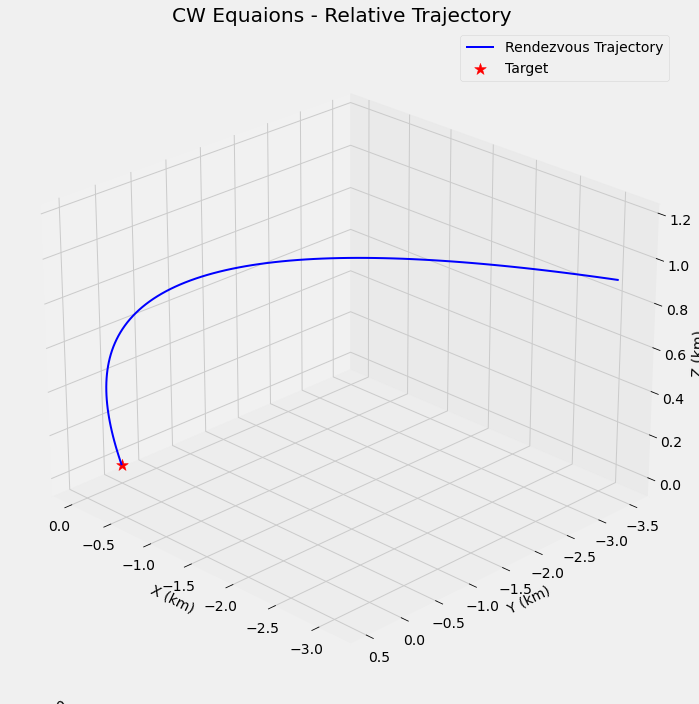

In [59]:
#### Analytical CW equations ####
def cw_state_transition_matrix(omega, t):
    c = np.cos(omega * t)
    s = np.sin(omega * t)

    phi = np.array([
        [4 - 3*c,      0,          0,     s/omega,          (2*(1-c))/omega,      0],
        [6*(s - omega*t), 1,       0,   -(2*(1-c))/omega,   -(4*s - 3*omega*t)/omega, 0],
        [0,            0,          c,     0,               0,                s/omega],
        [3*omega*s,    0,          0,     c,               -2*s,              0],
        [-6*omega*(1-c),0,          0,    -2*s,            -3 + 4*c,          0],
        [0,            0,     omega*s,   0,               0,                 c]
    ])
    return phi

# Function to propagate state using CW matrix defined above
def propagate_CW(r0, v0, omega, t):
    state0 = np.concatenate((r0, v0))
    phi = cw_state_transition_matrix(omega, t)
    state_t = phi @ state0
    r_t = state_t[:3]
    v_t = state_t[3:]
    return r_t, v_t

# Maneuver calculation for rendezvous. See equations 59-62 of [2] for further detail.
def calculate_maneuver(r_current, v_current, omega, t_go, r_target=np.array([10,1,1])):
    
    c = np.cos(omega * t)
    s = np.sin(omega * t)
    
    phi_rr = np.array([
        [4 - 3*c,      0,          0],
        [6*(s - omega*t), 1,       0],
        [0,            0,          c]
    ])
    phi_rv = np.array([
        [s/omega,      0,          0],
        [6*(s - omega*t), 1,       0],
        [0,            0,          c]
    ])
    phi_vr = np.linalg.pinv(phi_rv) 
    delta_v  = phi_vr @ (r_target - phi_rr @ r_current)
    return delta_v

# Simulation details
dt = 20
t1 = 10000
r1, v1 = propagate_CW(r_init, rdot_init, omega, t1)

# The first manuever for correction
t2 = 2000
delta_v1 = calculate_maneuver(r1, v1, omega, t2+t2)
new_v1 = v1 + delta_v1

# Use this new velocity to propogate system again 
r2, v2 = propagate_CW(r1, new_v1, omega, t2)

# Repeat until we compute the final velocity
delta_v2 = calculate_maneuver(r2, v2, omega, t2)
new_v2 = v2 + delta_v2
t3 = t2
r_final = []
times = np.arange(0, t3, dt)

for t in times:
    r_t, _ = propagate_CW(r2, new_v2, omega, t)
    r_final.append(r_t)

r_final = np.array(r_final)

# Plot the final trajectory
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*r_final.T, color='blue', linewidth=2, label='Rendezvous Trajectory')

# Plot the target, defined at origin
ax.scatter(0,0,0, color='red', marker='*', s=150, label='Target')

# Labels
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('CW Equaions - Relative Trajectory')
ax.legend()
ax.grid(True)
ax.view_init(elev=25, azim=135)
plt.tight_layout()
plt.show()


In [13]:

#### Define dynamics ####

def CW(t, sol, omega):
    '''
    Clohessy–Wiltshire equations
    '''
    x, y, z, xdot, ydot, zdot = sol
    x_ddot = 3 * omega**2 * x + 2*omega*ydot 
    y_ddot = -2 * omega * xdot
    z_ddot = -omega**2 * z

    return [xdot, ydot, zdot, x_ddot, y_ddot, z_ddot]

def solve_traj(r0, rdot0, omega, t_span, dt):
    '''
    Numerical solve with scipy 
    '''
    y0 = np.concatenate((r0, rdot0))
    t_eval = np.arange(t_span[0], t_span[1], dt)
    solution = solve_ivp(CW, t_span, y0, args=(omega,), t_eval=t_eval, method='RK45')
    return solution
    

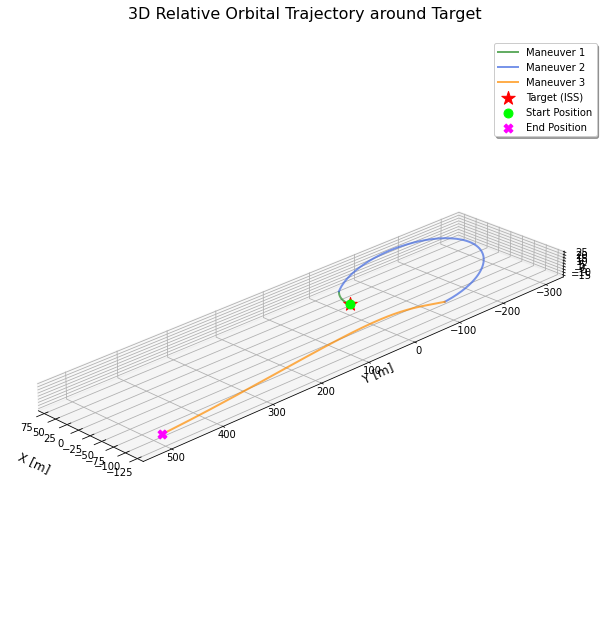

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#plt.style.use('fivethirtyeight')

# Constants
mu = 398600.5
R = 6870+405
omega = np.sqrt(mu / R**3)

# Initial conditions
r0 = np.array([0, 0, 0])
rdot0 = np.array([0.1, 0, 0])


def cw_equations(t, y, omega):
    x, y_pos, z, xdot, ydot, zdot = y

    xddot = 3 * omega**2 * x + 2 * omega * ydot
    yddot = -2 * omega * xdot
    zddot = -omega**2 * z

    return [xdot, ydot, zdot, xddot, yddot, zddot]

# Integrate the trajectory using scipy

def integrate_trajectory(r0, rdot0, omega, t_span, dt):
    y0 = np.concatenate((r0, rdot0))
    t_eval = np.arange(t_span[0], t_span[1], dt)
    solution = solve_ivp(cw_equations, t_span, y0, args=(omega,), t_eval=t_eval, method='RK45')
    return solution

# First maneuver
sol1 = integrate_trajectory(r0, rdot0, omega, (0, 20000), 20)
positions = sol1.y[:3].T
velocities = sol1.y[3:].T
distances = np.linalg.norm(positions, axis=1)

# Find the index where distance exceeds d_max
d_max = 50
indices = np.where(distances >= d_max)[0]
stindex = indices[0] if len(indices) > 0 else len(distances)

# Second maneuver
r0_2 = positions[stindex]
rdot0_2 = velocities[stindex] + np.array([-0.03, 0, 0.02])
sol2 = integrate_trajectory(r0_2, rdot0_2, omega, (0, 4000), 20)
positions2 = sol2.y[:3].T
velocities2 = sol2.y[3:].T

# Third maneuver
r0_3 = positions2[-1]
rdot0_3 = velocities2[-1] + np.array([0, -0.05, 0.03])
sol3 = integrate_trajectory(r0_3, rdot0_3, omega, (0, 4000), 20)
positions3 = sol3.y[:3].T

# Concatenate positions for plotting
all_positions = np.vstack((positions[:stindex], positions2, positions3))

# Improved 3D visualization with target
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory clearly as continuous lines
ax.plot(*positions[:stindex].T, color='forestgreen', linewidth=2, alpha=0.7, label='Maneuver 1')
ax.plot(*positions2.T, color='royalblue', linewidth=2, alpha=0.7, label='Maneuver 2')
ax.plot(*positions3.T, color='darkorange', linewidth=2, alpha=0.7, label='Maneuver 3')

# Clearly indicate target at origin
ax.scatter(0, 0, 0, color='red', marker='*', s=200, label='Target (ISS)')

# Mark initial and final positions
ax.scatter(*positions[0], color='lime', marker='o', s=80, label='Start Position')
ax.scatter(*positions3[-1], color='magenta', marker='X', s=80, label='End Position')

# Set labels with units
ax.set_xlabel('X [m]', fontsize=12, labelpad=15)
ax.set_ylabel('Y [m]', fontsize=12, labelpad=15)
ax.set_zlabel('Z [m]', fontsize=12, labelpad=15)

# Set title clearly indicating the purpose
ax.set_title('3D Relative Orbital Trajectory around Target', fontsize=16, pad=20)

# Equal aspect ratio to avoid distortion
ax.set_box_aspect([np.ptp(all_positions[:,0]), np.ptp(all_positions[:,1]), np.ptp(all_positions[:,2])])

# Grid and visual clarity
ax.grid(True, linestyle='--', alpha=0.5)

# Clear legend
ax.legend(loc='upper right', fontsize=10, shadow=True)

# Optimized viewing angle for better visualization
ax.view_init(elev=25, azim=135)

plt.tight_layout()
plt.show()



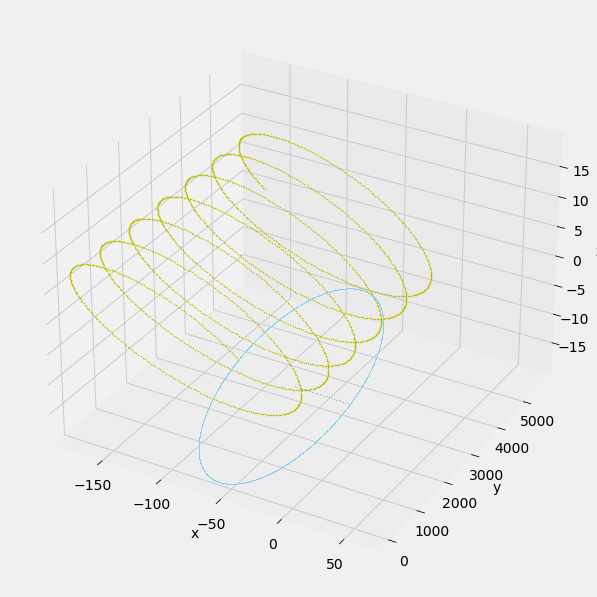

In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 23 13:38:54 2018

@author: bonar
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  9 16:22:46 2018

@author: bonar
"""

import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('fivethirtyeight')

r0 = [0, 0, 0]                  #initial starting position
rdot0 = [0.1, 0, 0]            #initial velocity (on release from ISS) (m/s)
R = 405 + 6870   
mu = 398600.5
omeg = math.sqrt(mu/R**3)

nframes = 10000
nframes2 = 2000
nframes3 = 2000
dt = 20

def CW(r0, rdot0, omeg, t):
    x0 = r0[0]
    y0 = r0[1]
    z0 = r0[2]
    xdot0 = rdot0[0]
    ydot0 = rdot0[1]
    zdot0 = rdot0[2]
    
    xt = (4*x0 + (2*ydot0)/omeg)+(xdot0/omeg)*math.sin(omeg*t)-(3*x0+(2*ydot0)/omeg)*math.cos(omeg*t)
    yt = (y0 - (2*xdot0)/omeg)+((2*xdot0)/omeg)*math.cos(omeg*t)+(6*x0 + (4*ydot0)/omeg)*math.sin(omeg*t)-(6*omeg*x0+3*ydot0)*t
    zt = z0*math.cos(omeg*t)+(zdot0/omeg)*math.sin(omeg*t)
    return([xt, yt, zt])
def CW2(r0, rdot0, omeg, t):
    x0 = r0[0]
    y0 = r0[1]
    z0 = r0[2]
    xdot0 = rdot0[0]
    ydot0 = rdot0[1]
    zdot0 = rdot0[2]
    
    xt = (4*x0 + (2*ydot0)/omeg)+(xdot0/omeg)*math.sin(omeg*t)-(3*x0+(2*ydot0)/omeg)*math.cos(omeg*t)
    yt = (y0 - (2*xdot0)/omeg)+((2*xdot0)/omeg)*math.cos(omeg*t)+(6*x0 + (4*ydot0)/omeg)*math.sin(omeg*t)-(6*omeg*x0+3*ydot0)*t
    zt = z0*math.cos(omeg*t)+(zdot0/omeg)*math.sin(omeg*t)
    
    xdott = (3*omeg*x0+2*ydot0)*math.sin(omeg*t)+xdot0*math.cos(omeg*t)
    ydott = (6*omeg*x0+4*ydot0)*math.cos(omeg*t)-2*xdot0*math.sin(omeg*t)-(6*omeg*x0+3*ydot0)
    zdott = zdot0*math.cos(omeg*t)-z0*omeg*math.sin(omeg*t)
    
    return([xt,yt,zt],[xdott,ydott,zdott])
        
xs = []
ys = []
zs = []
ds = []



d =0
d_max = 50
stindex = nframes
for i in range(nframes):
    t = dt*i
    if d<d_max:
        r_vec= CW2(r0, rdot0, omeg, t)[0]
        rdot_vec = CW2(r0, rdot0, omeg, t)[1]
        x = r_vec[0]
        y = r_vec[1]
        z = r_vec[2]
        xdot = rdot_vec[0]
        ydot = rdot_vec[1]
        zdot = rdot_vec[2]
        rdot = [xdot, ydot, zdot]
        d = math.sqrt(x**2+y**2+z**2)
        ds.append(d)
        
        xs.append(x)
        ys.append(y)
        zs.append(z)
        
        v = math.sqrt(xdot**2+ydot**2+zdot**2)
        stindex = i
    
#second manouvre
     
r0 = [x, y, z]
deltav = [-0.03, 0, 0.02]
for i in range(len(rdot)):
    rdot0[i] = rdot[i]+deltav[i]


for i in range(nframes2):
    t = dt*i
    r_vec= CW2(r0, rdot0, omeg, t)[0]
    rdot_vec = CW2(r0, rdot0, omeg, t)[1]
    x = r_vec[0]
    y = r_vec[1]
    z = r_vec[2]
    xdot = rdot_vec[0]
    ydot = rdot_vec[1]
    zdot = rdot_vec[2]
    rdot = [xdot, ydot, zdot]
    d = math.sqrt(x**2+y**2+z**2)
    ds.append(d)
    
    xs.append(x)
    ys.append(y)
    zs.append(z)
    
    v = math.sqrt(xdot**2+ydot**2+zdot**2)

#maonoeuvre 3

r0 = [x, y, z]
deltav = [0, -0.05, 0.03]
for i in range(len(rdot)):
    rdot0[i] = rdot[i]+deltav[i]  
  

for i in range(nframes3):
    t = dt*i
    r_vec= CW2(r0, rdot0, omeg, t)[0]
    rdot_vec = CW2(r0, rdot0, omeg, t)[1]
    x = r_vec[0]
    y = r_vec[1]
    z = r_vec[2]
    xdot = rdot_vec[0]
    ydot = rdot_vec[1]
    zdot = rdot_vec[2]
    
    d = math.sqrt(x**2+y**2+z**2)
    ds.append(d)
    
    xs.append(x)
    ys.append(y)
    zs.append(z)
    
    v = math.sqrt(xdot**2+ydot**2+zdot**2)

xmin = min(xs)
xmax = max(xs)
ymin = min(ys)
ymax = max(ys)
zmin = min(zs)
zmax = max(zs)
rmax = max(ds)




fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d',xlim = (xmin, xmax), ylim = (ymin, ymax),zlim = (zmin, zmax))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')  


frame = 0
while frame < stindex:
    frame +=1
    ax.scatter(xs[frame], ys[frame], zs[frame], marker = '.', color = 'g', alpha = 0.5, s=1)
    
while frame < nframes2+stindex:
    frame += 1
    ax.scatter(xs[frame], ys[frame], zs[frame], marker = '.', color = 'skyblue', s=1)
    
while frame < nframes3+nframes2+stindex:
    frame += 1
    ax.scatter(xs[frame], ys[frame], zs[frame], color = 'y', s=1)





    

In [1]:
import numpy as np
from scipy.linalg import expm

# Simplified linearized Clohessy-Wiltshire (Hill's) equations
# for rendezvous in circular orbit
mu = 398600.4418 # Earth's gravitational parameter, km^3/s^2
R = 6771 # Orbit radius (Earth radius + altitude), km
n = np.sqrt(mu / R**3) # mean motion, rad/s

# Dynamics matrix for linearized Hill's equations (2D planar rendezvous)
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [3*n**2, 0, 0, 2*n],
              [0, 0, -2*n, 0]])

# Process noise covariance (simplified assumption)
Q = np.eye(4) * 1e-6

# Initial covariance (position in km^2, velocity in (km/s)^2)
P0 = np.diag([1e-4, 1e-4, 1e-6, 1e-6])

# Time step and propagation time
step_time = 10  # seconds
simulation_time = 600  # total propagation time (10 minutes)
time_steps = simulation_time // step_time

# Initialize covariance
P = P0.copy()

# State Transition Matrix calculation and covariance propagation
for step in range(time_steps):
    Phi = expm(A * step_time)
    P = Phi @ P @ Phi.T + Q

# 3-sigma (99.7%) position and velocity dispersions
sigma_pos = 3 * np.sqrt(np.diag(P)[0:2])
sigma_vel = 3 * np.sqrt(np.diag(P)[2:4])

print('3-sigma Position Dispersion (km):', sigma_pos)
print('3-sigma Velocity Dispersion (km/s):', sigma_vel)

# Estimating Δv maneuver needed to correct position error at final step
# Simplified assumption: correcting position dispersion only
required_dv = sigma_pos * n
print('Estimated 3-sigma required Δv (km/s):', required_dv)


3-sigma Position Dispersion (km): [8.84146562 7.89157329]
3-sigma Velocity Dispersion (km/s): [0.02796242 0.024844  ]
Estimated 3-sigma required Δv (km/s): [0.01001876 0.00894238]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver

# Initial orbit of target spacecraft (circular orbit at 400 km altitude)
altitude = 400 * u.km
initial_orbit = Orbit.circular(Earth, altitude)

# Chaser spacecraft initially behind the target by ~100 km along-track
chaser_orbit = initial_orbit.propagate(-100 / initial_orbit.n)

# Rendezvous maneuver calculation (Hohmann transfer)
hohmann_transfer = Maneuver.hohmann(chaser_orbit, initial_orbit.a)

# Apply maneuver to chaser
transfer_orbit, final_orbit = chaser_orbit.apply_maneuver(hohmann_transfer, intermediate=True)

# Plot the rendezvous orbits
plt.figure(figsize=(10, 10))
ax = plt.gca()
initial_orbit.plot(label='Target Orbit', ax=ax)
chaser_orbit.plot(label='Chaser Initial Orbit', ax=ax)
transfer_orbit.plot(label='Transfer Orbit', ax=ax, linestyle='dashed')
final_orbit.plot(label='Chaser Final Orbit (Rendezvous)', ax=ax)

plt.title("Orbital Rendezvous Maneuver using Poliastro")
plt.legend()
plt.grid(True)
plt.show()


SystemError: initialization of _internal failed without raising an exception

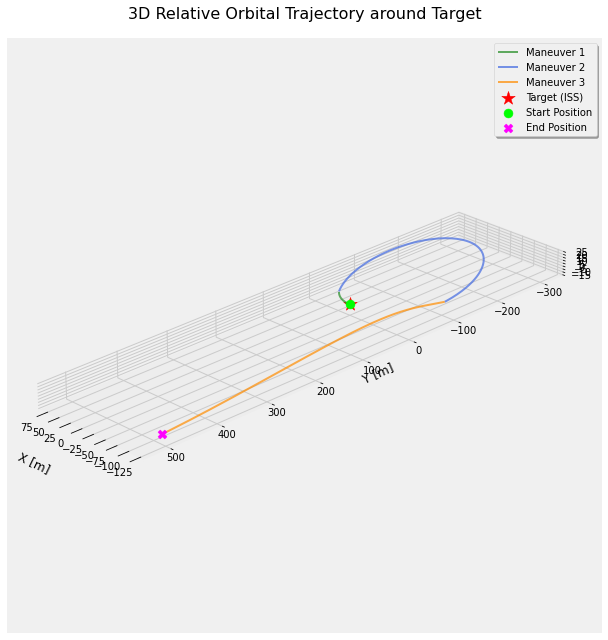

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#plt.style.use('fivethirtyeight')

# Constants
mu = 398600.5
R = 405 + 6870
omega = np.sqrt(mu / R**3)

# Initial conditions
r0 = np.array([0, 0, 0])
rdot0 = np.array([0.1, 0, 0])


def cw_equations(t, y, omega):
    x, y_pos, z, xdot, ydot, zdot = y

    xddot = 3 * omega**2 * x + 2 * omega * ydot
    yddot = -2 * omega * xdot
    zddot = -omega**2 * z

    return [xdot, ydot, zdot, xddot, yddot, zddot]

# Integrate the trajectory using scipy

def integrate_trajectory(r0, rdot0, omega, t_span, dt):
    y0 = np.concatenate((r0, rdot0))
    t_eval = np.arange(t_span[0], t_span[1], dt)
    solution = solve_ivp(cw_equations, t_span, y0, args=(omega,), t_eval=t_eval, method='RK45')
    return solution

# First maneuver
sol1 = integrate_trajectory(r0, rdot0, omega, (0, 20000), 20)
positions = sol1.y[:3].T
velocities = sol1.y[3:].T
distances = np.linalg.norm(positions, axis=1)

# Find the index where distance exceeds d_max
d_max = 50
indices = np.where(distances >= d_max)[0]
stindex = indices[0] if len(indices) > 0 else len(distances)

# Second maneuver
r0_2 = positions[stindex]
rdot0_2 = velocities[stindex] + np.array([-0.03, 0, 0.02])
sol2 = integrate_trajectory(r0_2, rdot0_2, omega, (0, 4000), 20)
positions2 = sol2.y[:3].T
velocities2 = sol2.y[3:].T

# Third maneuver
r0_3 = positions2[-1]
rdot0_3 = velocities2[-1] + np.array([0, -0.05, 0.03])
sol3 = integrate_trajectory(r0_3, rdot0_3, omega, (0, 4000), 20)
positions3 = sol3.y[:3].T

# Concatenate positions for plotting
all_positions = np.vstack((positions[:stindex], positions2, positions3))

# Improved 3D visualization with target
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory clearly as continuous lines
ax.plot(*positions[:stindex].T, color='forestgreen', linewidth=2, alpha=0.7, label='Maneuver 1')
ax.plot(*positions2.T, color='royalblue', linewidth=2, alpha=0.7, label='Maneuver 2')
ax.plot(*positions3.T, color='darkorange', linewidth=2, alpha=0.7, label='Maneuver 3')

# Clearly indicate target at origin
ax.scatter(0, 0, 0, color='red', marker='*', s=200, label='Target (ISS)')

# Mark initial and final positions
ax.scatter(*positions[0], color='lime', marker='o', s=80, label='Start Position')
ax.scatter(*positions3[-1], color='magenta', marker='X', s=80, label='End Position')

# Set labels with units
ax.set_xlabel('X [m]', fontsize=12, labelpad=15)
ax.set_ylabel('Y [m]', fontsize=12, labelpad=15)
ax.set_zlabel('Z [m]', fontsize=12, labelpad=15)

# Set title clearly indicating the purpose
ax.set_title('3D Relative Orbital Trajectory around Target', fontsize=16, pad=20)

# Equal aspect ratio to avoid distortion
ax.set_box_aspect([np.ptp(all_positions[:,0]), np.ptp(all_positions[:,1]), np.ptp(all_positions[:,2])])

# Grid and visual clarity
ax.grid(True, linestyle='--', alpha=0.5)

# Clear legend
ax.legend(loc='upper right', fontsize=10, shadow=True)

# Optimized viewing angle for better visualization
ax.view_init(elev=25, azim=135)

plt.tight_layout()
plt.show()

